# Quantum Simulated Annealing optimization using Monte Carlo methods

In [1]:
# Imports
%matplotlib inline
import numpy as np
import math
from random import randint
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['interactive'] == True
from scipy.optimize import minimize
from qiskit_aer.aerprovider import AerSimulator
from qiskit_aer import Aer, aerprovider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import HGate, ZGate
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import *

## Previous implementation

In [2]:
'''
Problem 3. Reversely find a parameter.

Input y is desired prepared quantum state. (L2 Normalized |y|^2 = 1)
Find parameters of variational quantum circuit "RealAmplitude" that can prepare y.
'''
def find_parameter(y):
    n = int(math.log2(len(y))) 
    ansatz = RealAmplitudes(n, reps=1) 
    parameters = np.ones(ansatz.num_parameters)  
    simulator = AerSimulator(method='statevector') 
    meas = ClassicalRegister(1, "meas") 
    qreg = QuantumRegister(2 * n + 1) 
    c = QuantumCircuit(qreg, meas) 

    # Prepare the circuit for the swap test
    a = [1]
    b = [n + 1]
    for i in range(2, n + 1):
        a.append(i)
        b.append(n + i)

    final = c.compose(ansatz, a) 
    final.initialize(y, b) 
    final.save_statevector(label="ans") 
    final.h(0) 

    # Perform the swap test
    for i in range(1, n + 1):
        final.cswap(0, i, n + i) 
    final.h(0) 
    final.measure([0], meas) 

    # Transpile and run the circuit
    circ = transpile(final, simulator) 
    circfinal = circ.assign_parameters(parameters) 
    results = simulator.run(circfinal).result() 
    print("Counts before optimization: " + str(results.get_counts())) 

    # Optimization
    Energy = E(parameters, circ, simulator) 
    anneal = SA(100, parameters, circ, simulator) 
    print(f"Energy: {Energy}") 

    # Update circuit with optimized parameters and run again
    circfinal = circ.assign_parameters(anneal)
    results = simulator.run(circfinal).result()
    counts = results.get_counts() 
    
    # Visualize results of the original implementation
    visualize_results(counts, "Before Optimization")

    # Calculate and print results
    b = counts.get('1', 0) 
    s = (1 - (2 / 1024) * b) 
    circfinal.draw(output="mpl") 
    matplotlib.pyplot.show() 
    optimized_counts = results.get_counts()
    print(f"After optimization: {str(results.get_counts())}") 
    print(f"Success value: {s}")

    # Visualize results of the Monte Carlo optimization
    visualize_results(optimized_counts, "After Optimization")

    # Calculate and print partial traces
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp)
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp)
    norm = np.linalg.norm(partial - partial2) 
    print("Norm of the difference between partial traces:", norm)

    return parameters 

# Function to calculate cost based on parameters
def cost_func(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=1024).result() 
    counts = results.get_counts() 
    b = counts.get('1', 0) 
    s = -1 * (1 - ((2 / 1024) * b)) 
    return s 

# Function to calculate energy based on parameters
def E(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=20).result() 
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp) 
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp) 
    norm = np.linalg.norm(partial - partial2) 
    return norm 

# Function for simulated annealing optimization
def SA(runs, params, ansatz, simulator):
    B = E(params, ansatz, simulator) 
    prev_E = B 

    # Temperature function for simulated annealing
    def T(t):
        c = 0.02
        a = 0.01
        temperature = c / (a + math.log(t)) 
        return temperature

    # Main loop for simulated annealing
    for t in range(1, runs):
        delta = np.random.normal(0, .1, 4) 
        params_new = params + delta 
        E_new = E(params_new, ansatz, simulator) 
        delta_E = E_new - prev_E 

        if delta_E <= 0:
            params = params_new
            prev_E = E_new
        else:
            h = math.pow(math.e, -1 * delta_E / T(t)) 
            U = np.random.normal(.5, .5, 1) 
            if U < h:
                params = params_new
                prev_E = E_new

    return params 

# Function to visualize the results of the quantum circuit
def visualize_results(counts, title):
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Measurement Outcome')
    plt.ylabel('Counts')
    plt.show()


[0.66820241 0.00867795 0.21694884 0.71159218]
Counts before optimization: {'1': 87, '0': 937}
Energy: 0.3202178107841953


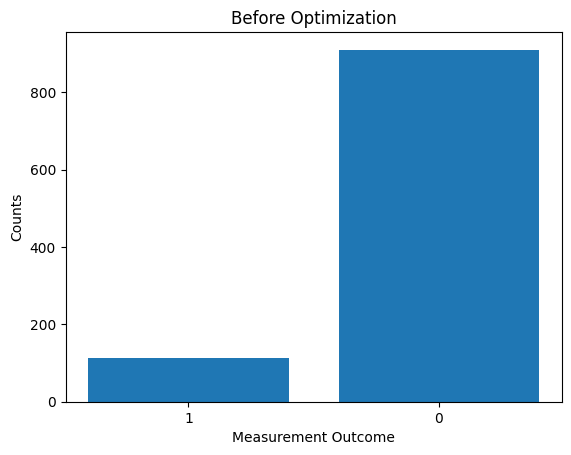

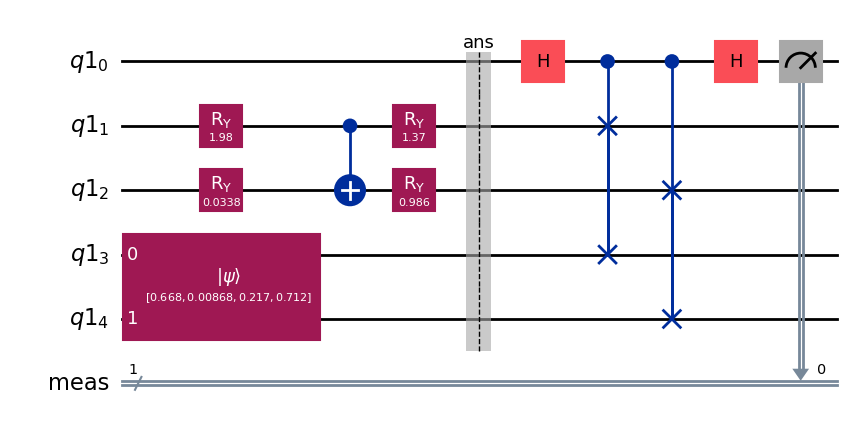

After optimization: {'1': 114, '0': 910}
Success value: 0.77734375


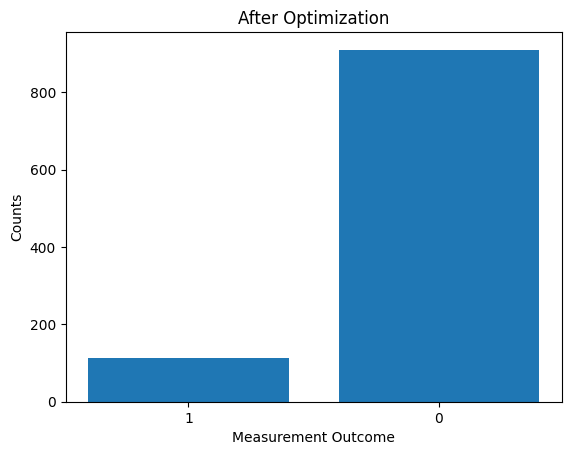

Norm of the difference between partial traces: 0.08930551123767584


In [3]:
# Main execution block
randvect = [randint(0, 100) for p in range(0, 4)] 
norm = np.linalg.norm(randvect) 
randvect = randvect / norm 
print(randvect) 
original_parameters = find_parameter(randvect)

## New implementation: optimization using Monte Carlo methods

In [4]:
# Function to perform Monte Carlo optimization
def monte_carlo_optimization(params, ansatz, simulator, iterations=1000):
    best_params = params
    best_energy = E(params, ansatz, simulator)
    
    for _ in range(iterations):
        # Generate new parameters by adding random noise
        delta = np.random.normal(0, 0.5, len(params))
        new_params = best_params + delta
        new_energy = E(new_params, ansatz, simulator)
        
        if new_energy < best_energy:
            best_energy = new_energy
            best_params = new_params
            
    return best_params

# Function to find parameters for the variational quantum circuit
def find_parameter_mc(y):
    n = int(math.log2(len(y)))
    ansatz = RealAmplitudes(n, reps=1)
    parameters = np.ones(ansatz.num_parameters)  # Initial guess
    simulator = AerSimulator(method='statevector')
    meas = ClassicalRegister(1, "meas")
    qreg = QuantumRegister(2 * n + 1)
    c = QuantumCircuit(qreg, meas)  # Assemble circuit

    # Prepare the circuit for the swap test
    a = [1]
    b = [n + 1]
    for i in range(2, n + 1):
        a.append(i)
        b.append(n + i)

    final = c.compose(ansatz, a)
    final.initialize(y, b)  # Initialize ancillas to input y
    final.save_statevector(label="ans")
    final.h(0)  # Apply Hadamard gate for swap test

    # Perform the swap test
    for i in range(1, n + 1):
        final.cswap(0, i, n + i)  # Controlled swap operation
    final.h(0)  # Final Hadamard for swap test
    final.measure([0], meas)

    # Transpile and run the circuit
    circ = transpile(final, simulator)  # Transpile for compatibility
    circfinal = circ.assign_parameters(parameters)
    # circfinal.draw(output="mpl") 
    results = simulator.run(circfinal).result()
    original_counts = results.get_counts()  # Get counts from the original run
    print("Before optimization: " + str(original_counts))
    
    # Visualize results of the original implementation
    visualize_results(original_counts, "Before Monte Carlo Optimization")

    # New Monte Carlo optimization
    optimized_parameters = monte_carlo_optimization(parameters, circ, simulator)
    circfinal = circ.assign_parameters(optimized_parameters)
    results = simulator.run(circfinal).result()
    monte_carlo_counts = results.get_counts()  # Get counts from the Monte Carlo run
    print("After optimization: " + str(monte_carlo_counts))
    
    # Visualize results of the Monte Carlo optimization
    visualize_results(monte_carlo_counts, "After Monte Carlo Optimization")
    
    return optimized_parameters  # Only return optimized parameters

[0.45302283 0.06863982 0.65207831 0.60403044]
Before optimization: {'1': 60, '0': 964}


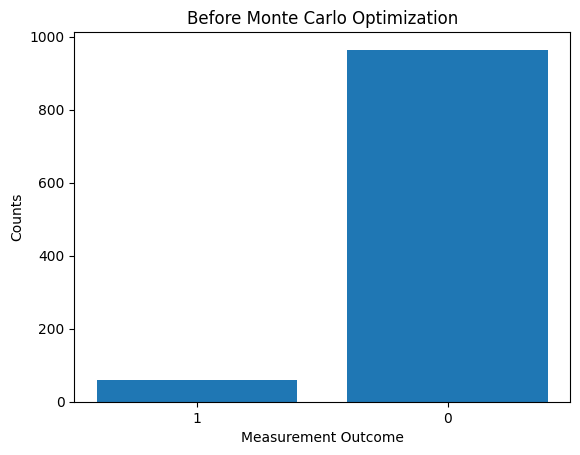

After optimization: {'1': 2, '0': 1022}


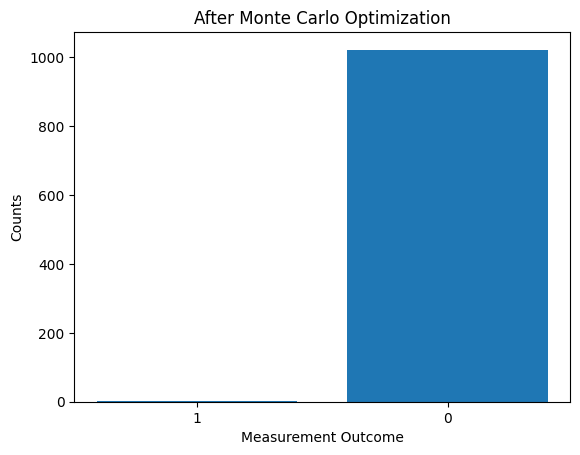

In [5]:
# Main execution block
randvect = [randint(0, 100) for p in range(0, 4)] 
norm = np.linalg.norm(randvect) 
randvect = randvect / norm 
print(randvect) 
optimized_parameters = find_parameter_mc(randvect)

# Compare the results